# Imports

In [2]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml 

# Constants

In [6]:
# --- Configuration ---
BASE_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset'
ORIGINAL_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Original_Data')
AUGMENTED_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Augmented_Data')

# Define paths for augmented data splits
TRAIN_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'labels')
VALID_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'images')
VALID_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'images')
TEST_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'labels')

# Step1: Verify Folder Structure

In [7]:
def check_and_count_files(dir_path, extensions=['.jpg', '.txt', '.json']):
    """Checks if a directory exists and counts files with given extensions."""
    if not os.path.isdir(dir_path):
        print(f"Directory NOT FOUND: {dir_path}")
        return None
    
    counts = {ext: 0 for ext in extensions}
    all_files = glob.glob(os.path.join(dir_path, '*'))
    
    for f in all_files:
        for ext in extensions:
            if f.lower().endswith(ext):
                counts[ext] += 1
                break # Count each file only once based on the first matching extension
                
    count_str = ", ".join([f"{count} {ext}" for ext, count in counts.items() if count > 0])
    print(f"Found: {dir_path} - Contains: {count_str if count_str else '0 files specified'}")
    return counts

# Check Original Data
print("\n[Original Data]")
# Note: Original data description mentions .json labels, but the folder structure implies .txt. Let's check both.
# Correction based on user prompt: Original_Data also has .txt labels.
original_img_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))
original_lbl_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.txt'))
print(f"Found: {ORIGINAL_DATA_DIR}")
print(f"  - Images (.jpg): {len(original_img_files)}")
print(f"  - Labels (.txt): {len(original_lbl_files)}")
# If JSON exists, check them too:
original_json_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.json'))
if original_json_files:
    print(f"  - Labels (.json): {len(original_json_files)}")


# Check Augmented Data
print("\n[Augmented Data]")
train_img_count = len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
train_lbl_count = len(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))
valid_img_count = len(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
valid_lbl_count = len(glob.glob(os.path.join(VALID_LBL_DIR, '*.txt')))
test_img_count = len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))
test_lbl_count = len(glob.glob(os.path.join(TEST_LBL_DIR, '*.txt')))

print(f"Train: Images={train_img_count}, Labels={train_lbl_count}")
print(f"Valid: Images={valid_img_count}, Labels={valid_lbl_count}")
print(f"Test:  Images={test_img_count}, Labels={test_lbl_count}")

# Basic consistency check
if train_img_count != train_lbl_count or valid_img_count != valid_lbl_count or test_img_count != test_lbl_count:
    print("\n*** WARNING: Mismatch between image and label counts in augmented data splits! ***")
else:
    print("\nImage and label counts match in augmented data splits.")


[Original Data]
Found: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Original_Data
  - Images (.jpg): 232
  - Labels (.txt): 232

[Augmented Data]
Train: Images=567, Labels=558
Valid: Images=23, Labels=23
Test:  Images=23, Labels=23

*** WARNING: Mismatch between image and label counts in augmented data splits! ***


## Step 2: Examine Label Format (YOLO Detection)

In [9]:
def examine_label_file_detection(label_path):
    """Reads a YOLO detection label file and prints its format info."""
    print(f"\nExamining: {label_path}")
    if not os.path.exists(label_path):
        print("File not found.")
        return None

    lines_info = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print("Label file is empty.")
            return []

        print(f"Number of bounding boxes (lines): {len(lines)}")

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 5: # Expecting class_id cx cy w h
                 print(f"  - Line {i+1}: Invalid format - expected 5 parts, found {len(parts)}. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'parts': len(parts), 'content': line.strip()})
                 continue

            try:
                class_id = int(parts[0])
                cx = float(parts[1])
                cy = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                coords = np.array([cx, cy, w, h])

                if not np.all((coords >= 0.0) & (coords <= 1.0)):
                    print(f"  - Line {i+1}: Invalid format - coordinates or dimensions out of [0, 1] range. Class: {class_id}, Values: {coords}")
                    lines_info.append({'valid': False, 'class': class_id, 'coords': coords.tolist(), 'content': line.strip()})
                else:
                    info = {'valid': True, 'class': class_id, 'cx': cx, 'cy': cy, 'w': w, 'h': h}
                    lines_info.append(info)
                    if i < 5: # Print details only for the first few lines
                         print(f"  - Line {i+1}: Class={class_id}, CenterX={cx:.4f}, CenterY={cy:.4f}, Width={w:.4f}, Height={h:.4f}")

            except ValueError:
                 print(f"  - Line {i+1}: Invalid format - non-numeric values found. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'content': line.strip()})

    except Exception as e:
        print(f"Error reading or parsing {label_path}: {e}")
        return None

    return lines_info

# Examine one label file from the training set
sample_label_files = glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))
if sample_label_files:
    examine_label_file_detection(random.choice(sample_label_files))
else:
    print("No label files found in training set to examine.")


Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/185_jpg.rf.809a88a8626c69444da4ff95c161abab.txt
Number of bounding boxes (lines): 9
  - Line 1: Class=5, CenterX=0.0563, CenterY=0.3770, Width=0.1125, Height=0.1832
  - Line 2: Class=5, CenterX=0.2836, CenterY=0.1204, Width=0.0984, Height=0.2408
  - Line 3: Class=5, CenterX=0.9539, CenterY=0.0772, Width=0.0922, Height=0.1545
  - Line 4: Class=2, CenterX=0.5959, CenterY=0.1145, Width=0.0707, Height=0.1499
  - Line 5: Class=5, CenterX=0.9494, CenterY=0.2298, Width=0.0608, Height=0.1934


## Step 3: Visualize Sample Images and Bounding Boxes


--- Visualizing Training Samples ---

Visualizing: 236_jpg.rf.40062d765de333925a75e56eec6da905.jpg
Image dimensions (HxW): 351 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/236_jpg.rf.40062d765de333925a75e56eec6da905.txt
Number of bounding boxes (lines): 9
  - Line 1: Class=5, CenterX=0.0367, CenterY=0.1211, Width=0.0734, Height=0.2194
  - Line 2: Class=5, CenterX=0.1609, CenterY=0.4418, Width=0.0894, Height=0.2681
  - Line 3: Class=5, CenterX=0.3445, CenterY=0.4772, Width=0.0797, Height=0.2251
  - Line 4: Class=5, CenterX=0.7898, CenterY=0.4221, Width=0.0935, Height=0.2458
  - Line 5: Class=5, CenterX=0.5628, CenterY=0.2163, Width=0.0669, Height=0.1804
Drawn 9 bounding boxes.


/tmp/ipykernel_31/936133588.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)


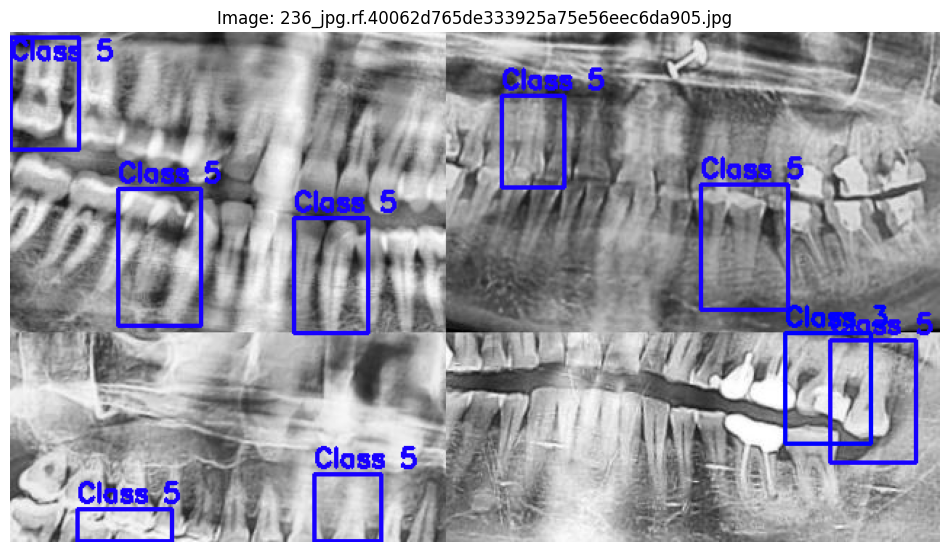


Visualizing: 247_jpg.rf.d3d103815d9ec4f3d02f15d3ea12017c.jpg
Image dimensions (HxW): 384 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/247_jpg.rf.d3d103815d9ec4f3d02f15d3ea12017c.txt
Number of bounding boxes (lines): 8
  - Line 1: Class=5, CenterX=0.1815, CenterY=0.2441, Width=0.0818, Height=0.2515
  - Line 2: Class=5, CenterX=0.4109, CenterY=0.3138, Width=0.0844, Height=0.1901
  - Line 3: Class=5, CenterX=0.0945, CenterY=0.3685, Width=0.0922, Height=0.0807
  - Line 4: Class=5, CenterX=0.3453, CenterY=0.3021, Width=0.0813, Height=0.2135
  - Line 5: Class=5, CenterX=0.0125, CenterY=0.1081, Width=0.0250, Height=0.2161
Drawn 8 bounding boxes.


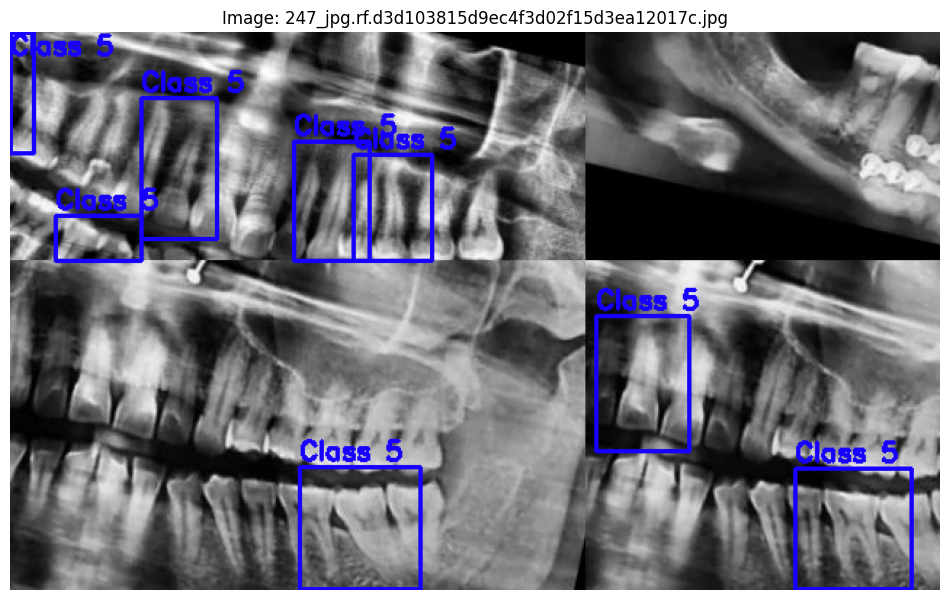


--- Visualizing Validation Samples ---

Visualizing: 42_jpg.rf.aea2d4e19ad98bded7f10429b293d510.jpg
Image dimensions (HxW): 340 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/42_jpg.rf.aea2d4e19ad98bded7f10429b293d510.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=0, CenterX=0.6766, CenterY=0.5324, Width=0.0594, Height=0.2324
  - Line 2: Class=2, CenterX=0.2375, CenterY=0.4853, Width=0.0781, Height=0.1294
  - Line 3: Class=2, CenterX=0.7766, CenterY=0.4941, Width=0.0828, Height=0.1647
  - Line 4: Class=0, CenterX=0.6656, CenterY=0.7647, Width=0.0766, Height=0.2353
  - Line 5: Class=0, CenterX=0.3219, CenterY=0.5412, Width=0.0656, Height=0.2029
Drawn 7 bounding boxes.


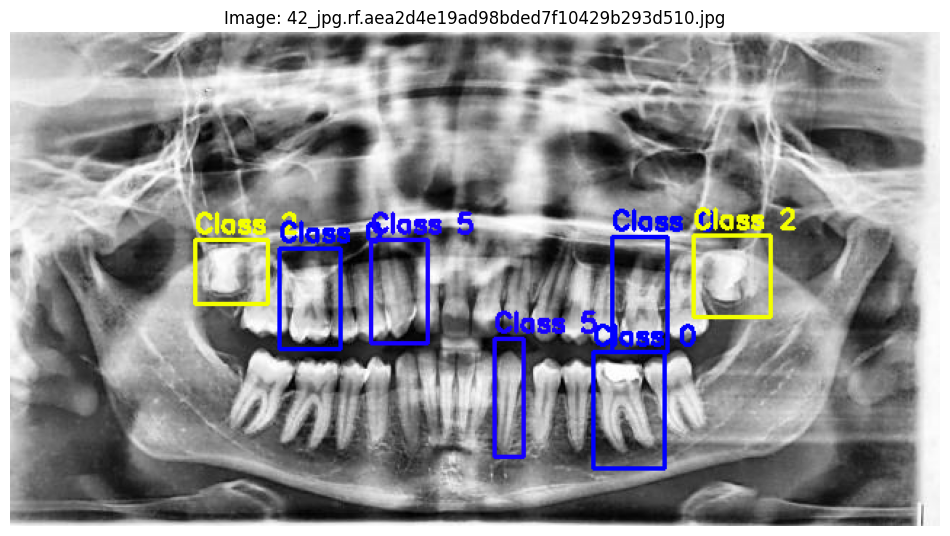


Visualizing: 184_jpg.rf.59618034addf45c96cc8f7a3a95199ab.jpg
Image dimensions (HxW): 318 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/184_jpg.rf.59618034addf45c96cc8f7a3a95199ab.txt
Number of bounding boxes (lines): 1
  - Line 1: Class=5, CenterX=0.7375, CenterY=0.7547, Width=0.1250, Height=0.1824
Drawn 1 bounding boxes.


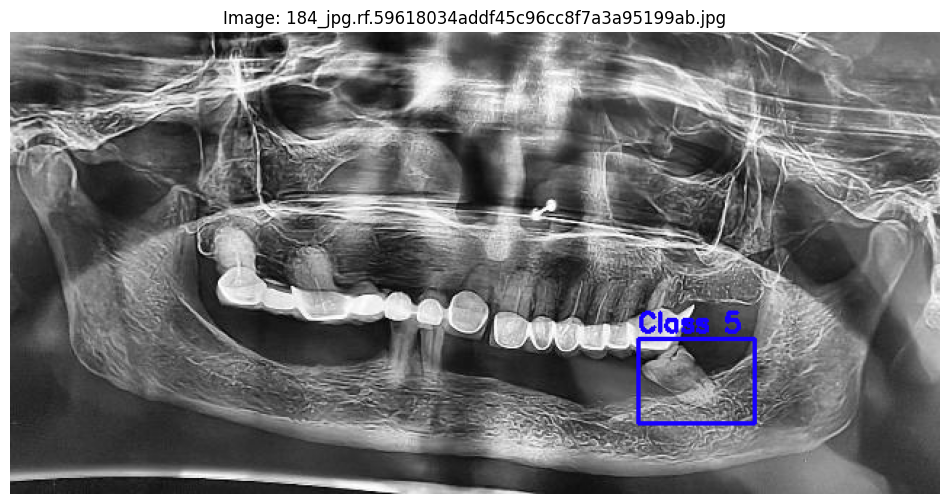


--- Visualizing Test Samples ---

Visualizing: 241_jpg.rf.3c014d1957e9444cb44590b9e905a08b.jpg
Image dimensions (HxW): 289 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/241_jpg.rf.3c014d1957e9444cb44590b9e905a08b.txt
Number of bounding boxes (lines): 5
  - Line 1: Class=5, CenterX=0.2547, CenterY=0.7301, Width=0.0750, Height=0.2422
  - Line 2: Class=5, CenterX=0.5750, CenterY=0.8028, Width=0.0437, Height=0.2768
  - Line 3: Class=5, CenterX=0.7688, CenterY=0.6609, Width=0.0922, Height=0.1903
  - Line 4: Class=5, CenterX=0.3672, CenterY=0.5260, Width=0.0469, Height=0.2699
  - Line 5: Class=5, CenterX=0.6094, CenterY=0.5017, Width=0.0516, Height=0.2768
Drawn 5 bounding boxes.


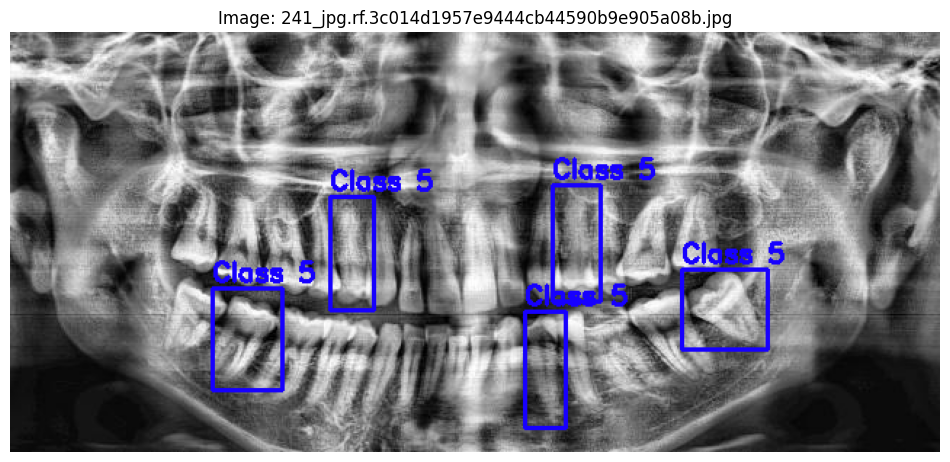


Visualizing: 208_jpg.rf.ab35fe79cc01f3a5f5b859a355281587.jpg
Image dimensions (HxW): 352 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/208_jpg.rf.ab35fe79cc01f3a5f5b859a355281587.txt
Number of bounding boxes (lines): 3
  - Line 1: Class=2, CenterX=0.8016, CenterY=0.6222, Width=0.1125, Height=0.1562
  - Line 2: Class=5, CenterX=0.7234, CenterY=0.5000, Width=0.0672, Height=0.2244
  - Line 3: Class=5, CenterX=0.2547, CenterY=0.4773, Width=0.0750, Height=0.2017
Drawn 3 bounding boxes.


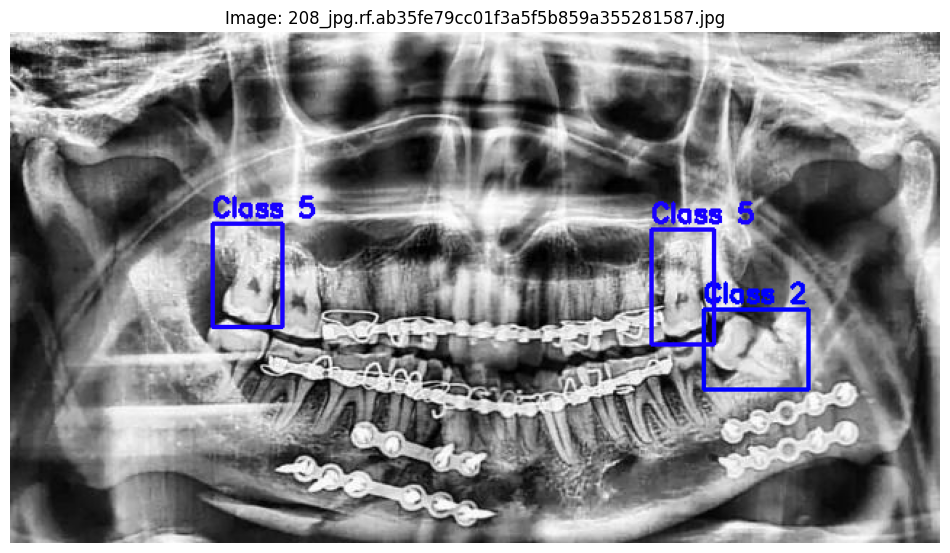

In [10]:
def display_image_with_boxes(image_path, label_path, num_samples=1):
    """Loads an image and its corresponding YOLO detection label, then displays them."""
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        # Optionally display the image without boxes if label is missing
        # img = cv2.imread(image_path)
        # if img is not None:
        #     plt.figure(figsize=(10, 7))
        #     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #     plt.title(f"Image: {os.path.basename(image_path)} (No Label Found)")
        #     plt.axis('off')
        #     plt.show()
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img_h, img_w = img.shape[:2]
    img_display = img.copy() # Work on a copy

    print(f"\nVisualizing: {os.path.basename(image_path)}")
    print(f"Image dimensions (HxW): {img_h} x {img_w}")

    lines_info = examine_label_file_detection(label_path) # Use updated examination function

    if lines_info is None or not lines_info:
        print("No valid bounding boxes found or error reading label file.")
    else:
        # Generate distinct colors for classes
        valid_classes = [info['class'] for info in lines_info if info['valid']]
        unique_classes = sorted(list(set(valid_classes))) if valid_classes else []
        # Use a colormap suitable for potentially many classes
        colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)
        class_colors = {cls: tuple(int(c*255) for c in colors(i)[:3]) for i, cls in enumerate(unique_classes)} # BGR for OpenCV

        box_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: continue # Skip invalid lines

                try:
                    class_id = int(parts[0])
                    cx = float(parts[1])
                    cy = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Denormalize coordinates and dimensions
                    center_x_abs = cx * img_w
                    center_y_abs = cy * img_h
                    box_w_abs = w * img_w
                    box_h_abs = h * img_h

                    # Calculate top-left (x1, y1) and bottom-right (x2, y2) coordinates
                    x1 = int(center_x_abs - box_w_abs / 2)
                    y1 = int(center_y_abs - box_h_abs / 2)
                    x2 = int(center_x_abs + box_w_abs / 2)
                    y2 = int(center_y_abs + box_h_abs / 2)

                    # Ensure coordinates are within image bounds (important for drawing)
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w - 1, x2)
                    y2 = min(img_h - 1, y2)

                    color = class_colors.get(class_id, (0, 0, 255)) # Default to red if class not found
                    label_text = f"Class {class_id}" # You might want to map this to actual names later

                    # Draw the bounding box rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness=2)
                    # Add class label text above the box
                    cv2.putText(img_display, label_text, (x1, y1 - 5 if y1 > 10 else y1 + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    box_count += 1

                except Exception as e:
                    print(f"Error processing line for drawing: {line.strip()} - {e}")
        print(f"Drawn {box_count} bounding boxes.")


    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for plt
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Get lists of files (Keep as before)
train_image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
valid_image_files = sorted(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
test_image_files = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))

# Visualize a few samples from each split (Use updated function name)
num_samples_to_show = 2

print("\n--- Visualizing Training Samples ---")
for i in range(min(num_samples_to_show, len(train_image_files))):
    idx = random.randint(0, len(train_image_files)-1) # Pick random samples
    img_file = train_image_files[idx]
    lbl_file = os.path.join(TRAIN_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Validation Samples ---")
for i in range(min(num_samples_to_show, len(valid_image_files))):
    idx = random.randint(0, len(valid_image_files)-1)
    img_file = valid_image_files[idx]
    lbl_file = os.path.join(VALID_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Test Samples ---")
for i in range(min(num_samples_to_show, len(test_image_files))):
    idx = random.randint(0, len(test_image_files)-1)
    img_file = test_image_files[idx]
    lbl_file = os.path.join(TEST_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function



## Step 4: Basic Statistics

In [11]:
image_widths = []
image_heights = []
boxes_per_image = [] # Changed name from segments_per_image
all_class_ids = set()
empty_label_files = 0

train_label_files = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))

for lbl_file in train_label_files:
    img_file = os.path.join(TRAIN_IMG_DIR, os.path.basename(lbl_file).replace('.txt', '.jpg'))

    if not os.path.exists(img_file):
        print(f"Warning: Corresponding image not found for label {lbl_file}")
        continue

    # Image dimensions (Keep as before)
    try:
        # Optimization: Use cv2.imread only once if needed for both stats and visualization later
        # Or use a library like PIL to get dimensions without loading the full image if memory is a concern
        img = cv2.imread(img_file)
        if img is not None:
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)
        else:
            print(f"Warning: Could not read image {img_file}")
            continue
    except Exception as e:
        print(f"Error reading image {img_file}: {e}")
        continue

    # Label info (Logic adapted for detection format)
    try:
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        num_boxes = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5: # Check for valid detection line format
                num_boxes += 1
                try:
                    all_class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Non-integer class ID found in {lbl_file}: {parts[0]}")
            elif parts: # If line is not empty but has wrong format
                 print(f"Warning: Invalid line format in {lbl_file}: '{line.strip()}'")


        boxes_per_image.append(num_boxes)

        if num_boxes == 0 and lines: # Label file exists but has no valid lines or is empty
             print(f"Warning: Label file {lbl_file} seems empty or contains only invalid lines.")
             if not lines:
                 empty_label_files += 1 # Count files that are truly empty


    except Exception as e:
        print(f"Error reading or processing label file {lbl_file}: {e}")

# Summary (Keep variable names consistent)
print(f"\nStatistics based on {len(train_label_files)} training labels:")
if image_widths:
    print(f"Image Widths: Min={np.min(image_widths)}, Max={np.max(image_widths)}, Avg={np.mean(image_widths):.2f}")
    print(f"Image Heights: Min={np.min(image_heights)}, Max={np.max(image_heights)}, Avg={np.mean(image_heights):.2f}")
    # Consider plotting histograms if needed
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.hist(image_widths, bins=20)
    # plt.title('Image Width Distribution (Train)')
    # plt.subplot(1, 2, 2)
    # plt.hist(image_heights, bins=20)
    # plt.title('Image Height Distribution (Train)')
    # plt.tight_layout()
    # plt.show()

if boxes_per_image:
    print(f"Bounding Boxes per Image: Min={np.min(boxes_per_image)}, Max={np.max(boxes_per_image)}, Avg={np.mean(boxes_per_image):.2f}")
    print(f"Number of completely empty label files: {empty_label_files}") # Clarified meaning
    # Consider plotting histogram
    # plt.figure(figsize=(6, 4))
    # plt.hist(boxes_per_image, bins=max(10, np.max(boxes_per_image) // 2 if np.max(boxes_per_image) > 0 else 10)) # Adjust bins
    # plt.title('Boxes per Image Distribution (Train)')
    # plt.show()

print(f"Unique Class IDs found: {sorted(list(all_class_ids))}")
if len(all_class_ids) > 0:
    print(f"This confirms a detection task with {len(all_class_ids)} classes.")
    print("You will need to define the names for these classes in your dataset.yaml file.")
else:
     print("Warning: No valid class IDs were found in the training labels.")




Statistics based on 558 training labels:
Image Widths: Min=639, Max=640, Avg=639.99
Image Heights: Min=250, Max=485, Avg=349.64
Bounding Boxes per Image: Min=1, Max=25, Avg=10.11
Number of completely empty label files: 0
Unique Class IDs found: [0, 1, 2, 3, 4, 5]
This confirms a detection task with 6 classes.
You will need to define the names for these classes in your dataset.yaml file.
